# Import Necessary Libraries

In [99]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm

gc.enable()

In [34]:
print(os.listdir("../input/"))

['diabetic-retinopathy-resized', 'aptos2019-blindness-detection']


# Explanatory Data Analysis

In [35]:
SEED = 7
np.random.seed(SEED)
set_random_seed(SEED)
dir_path = "../input/aptos2019-blindness-detection/"
IMG_DIM = 512  # 224 399 #
BATCH_SIZE = 12
CHANNEL_SIZE = 3
NUM_EPOCHS = 60
TRAIN_DIR = 'train_images'
TEST_DIR = 'test_images'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

In [36]:
df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))
NUM_CLASSES = df_train['diagnosis'].nunique()

In [37]:
df_train.head(2)

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4

In [38]:
df_test.head(2)

id_code
0  0005cfc8afb6
1  003f0afdcd15

In [39]:
print("Training set has {} samples and {} classes.".format(df_train.shape[0], df_train.shape[1]))
print("Testing set has {} samples and {} classes.".format(df_test.shape[0], df_test.shape[1]))

Training set has 3662 samples and 2 classes.
Testing set has 1928 samples and 1 classes.


# Data Visualisation

In [40]:
df_train.columns

Index(['id_code', 'diagnosis'], dtype='object')

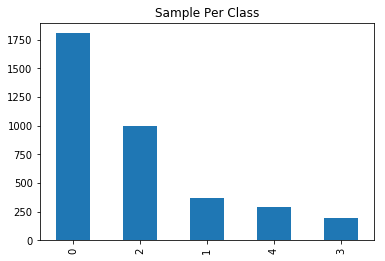

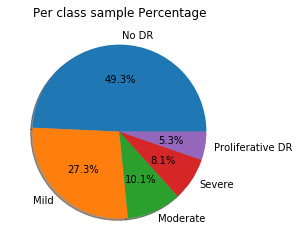

In [41]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

# Train and Test Dataset

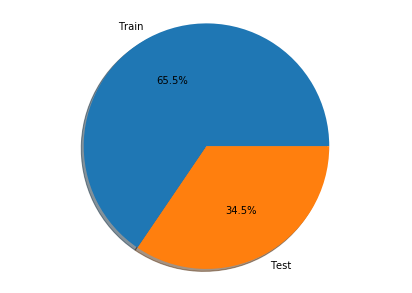

In [42]:
# Train & Test samples ratio
# Plot Data
labels = 'Train', 'Test'
sizes = df_train.shape[0], df_test.shape[0]
colors = 'lightskyblue', 'lightcoral'
# Plot
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

# Split the DataSet

In [43]:
x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,random_state=SEED, stratify=df_train.diagnosis)

In [44]:
def draw_img(imgs, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

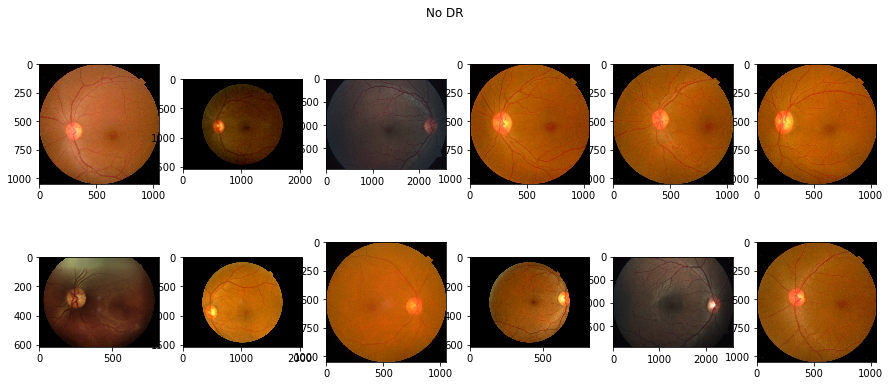

In [45]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

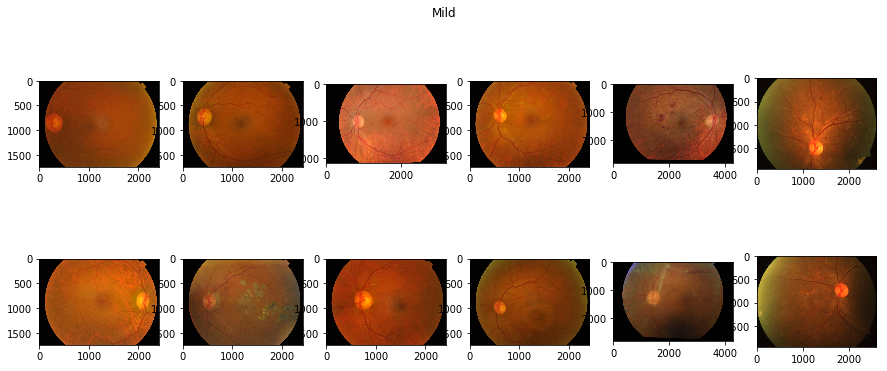

In [46]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])


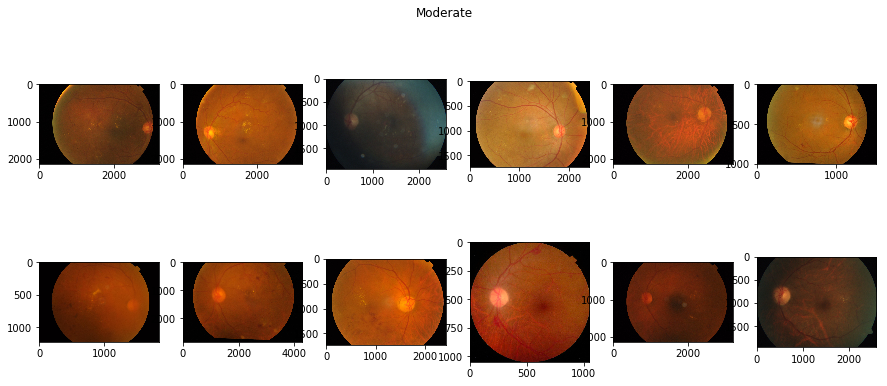

In [47]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])


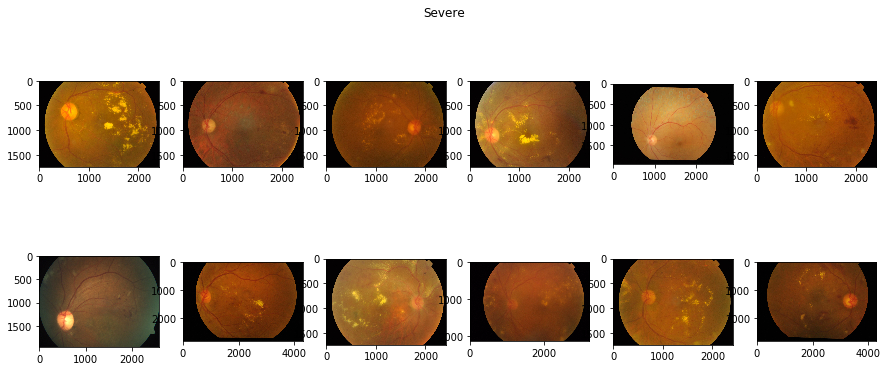

In [48]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])


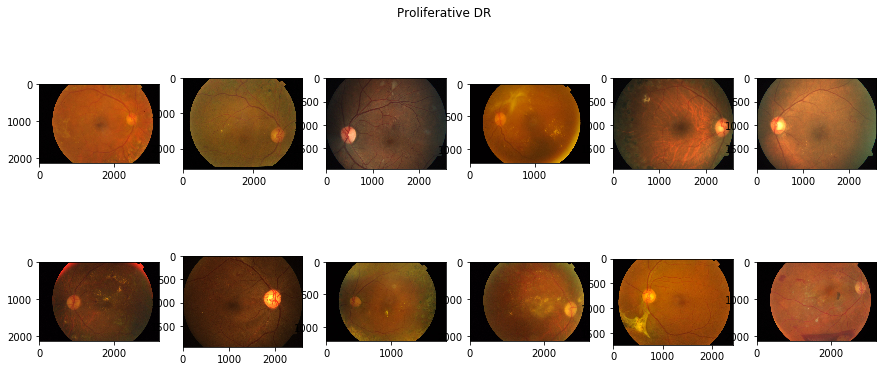

In [49]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])


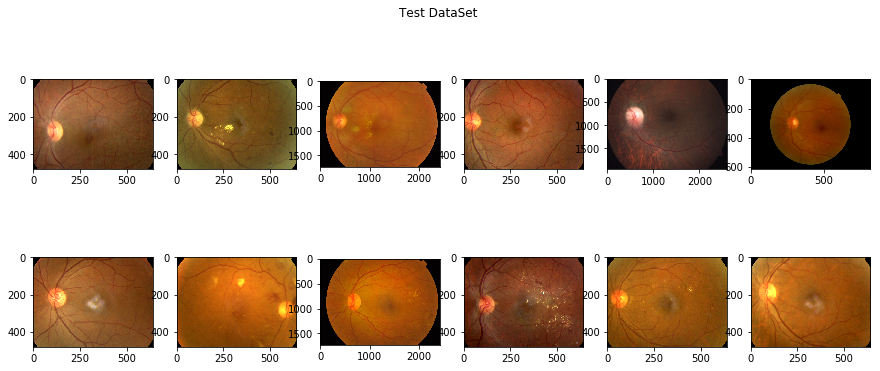

In [50]:
CLASS_ID = 'Test DataSet'
draw_img(df_test.sample(12, random_state=SEED), 'test_images', CLASS_ID)

# Max,Min Height and Width

In [51]:
def check_max_min_img_height_width(df, img_dir):
    max_Height , max_Width =0 ,0
    min_Height , min_Width =sys.maxsize ,sys.maxsize 
    for idx, row in df.iterrows():
        imgPath=os.path.join(dir_path,f"{img_dir}/{row['id_code']}.png") 
        img=cv2.imread(imgPath)
        H,W=img.shape[:2]
        max_Height=max(H,max_Height)
        max_Width =max(W,max_Width)
        min_Height=min(H,min_Height)
        min_Width =min(W,min_Width)
    return max_Height, max_Width, min_Height, min_Width

In [ ]:
check_max_min_img_height_width(df_train, TRAIN_DIR)

In [ ]:
check_max_min_img_height_width(df_test, TEST_DIR)

# InputImages

CPU times: user 3.16 s, sys: 42.9 ms, total: 3.2 s
Wall time: 27.8 s


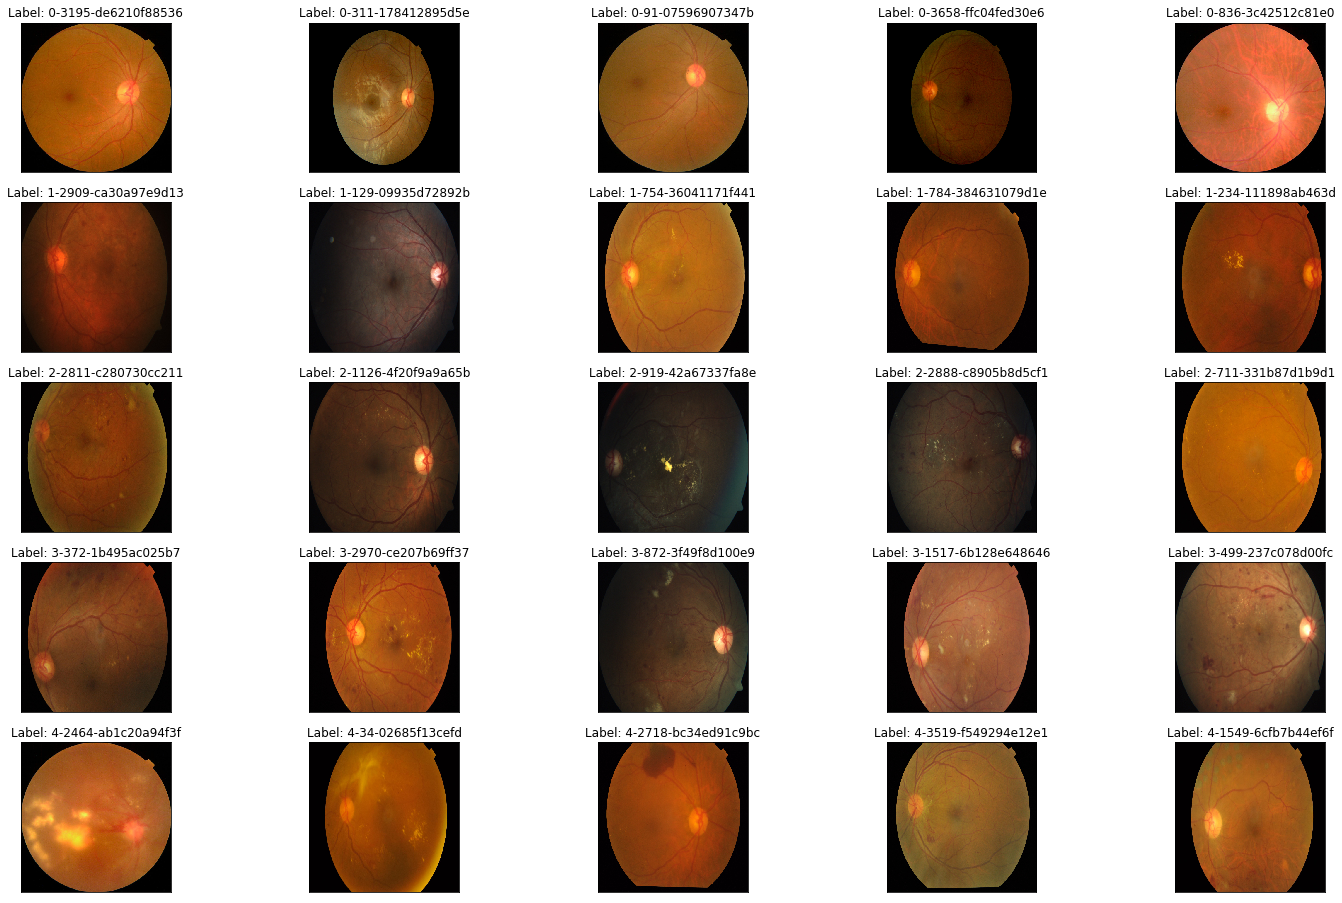

In [68]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_DIM, IMG_DIM))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
        

CPU times: user 3 s, sys: 28.5 ms, total: 3.03 s
Wall time: 2.95 s


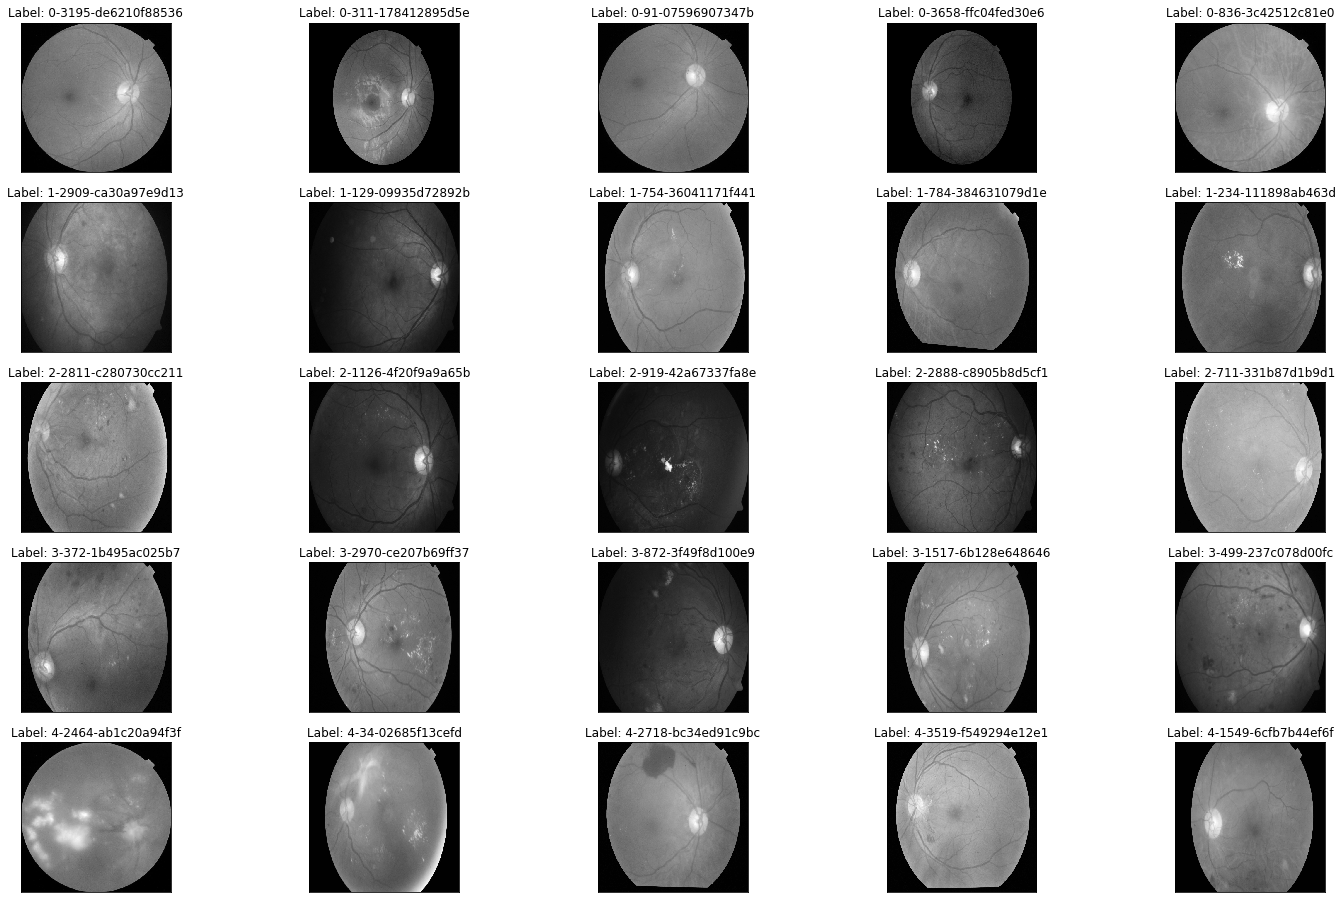

In [69]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_DIM, IMG_DIM))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

2136 3216


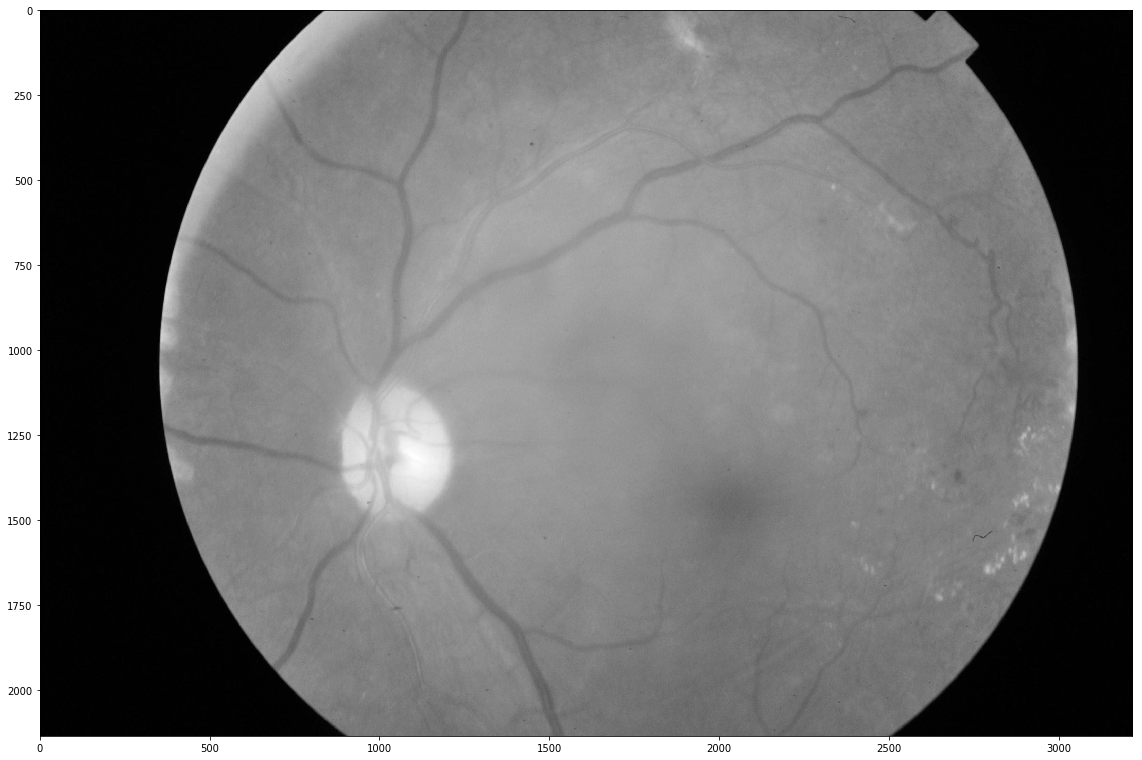

In [70]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, this still looks not so severe, can be class3
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape
print(height, width)

SCALE=2
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

# BGH Processing Method

CPU times: user 12.6 s, sys: 40.6 ms, total: 12.7 s
Wall time: 8.32 s


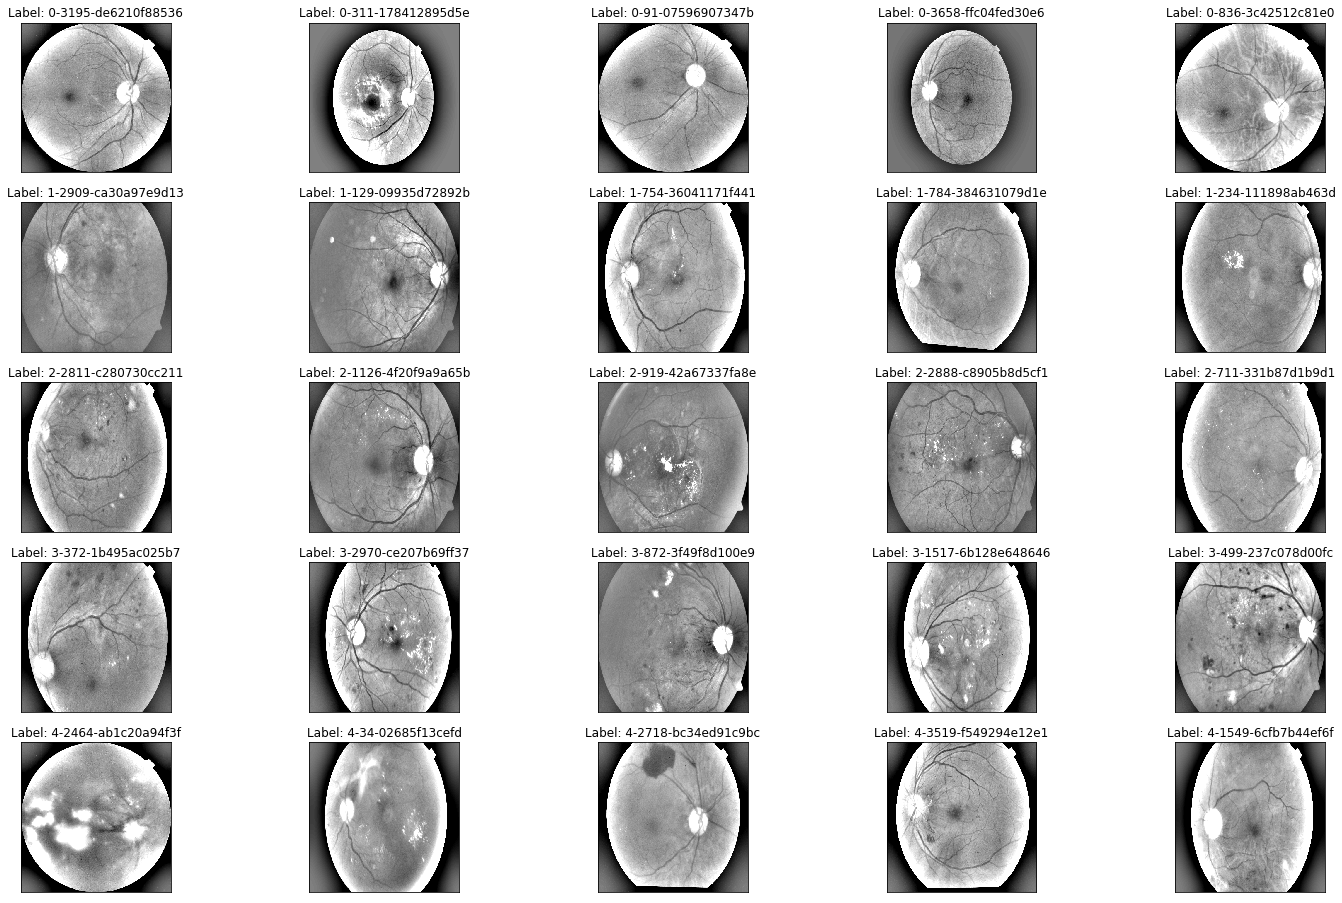

In [71]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_DIM, IMG_DIM))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_DIM/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Auto Cropping

In [72]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [73]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_DIM, IMG_DIM))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

CPU times: user 17 s, sys: 45.9 ms, total: 17 s
Wall time: 13 s


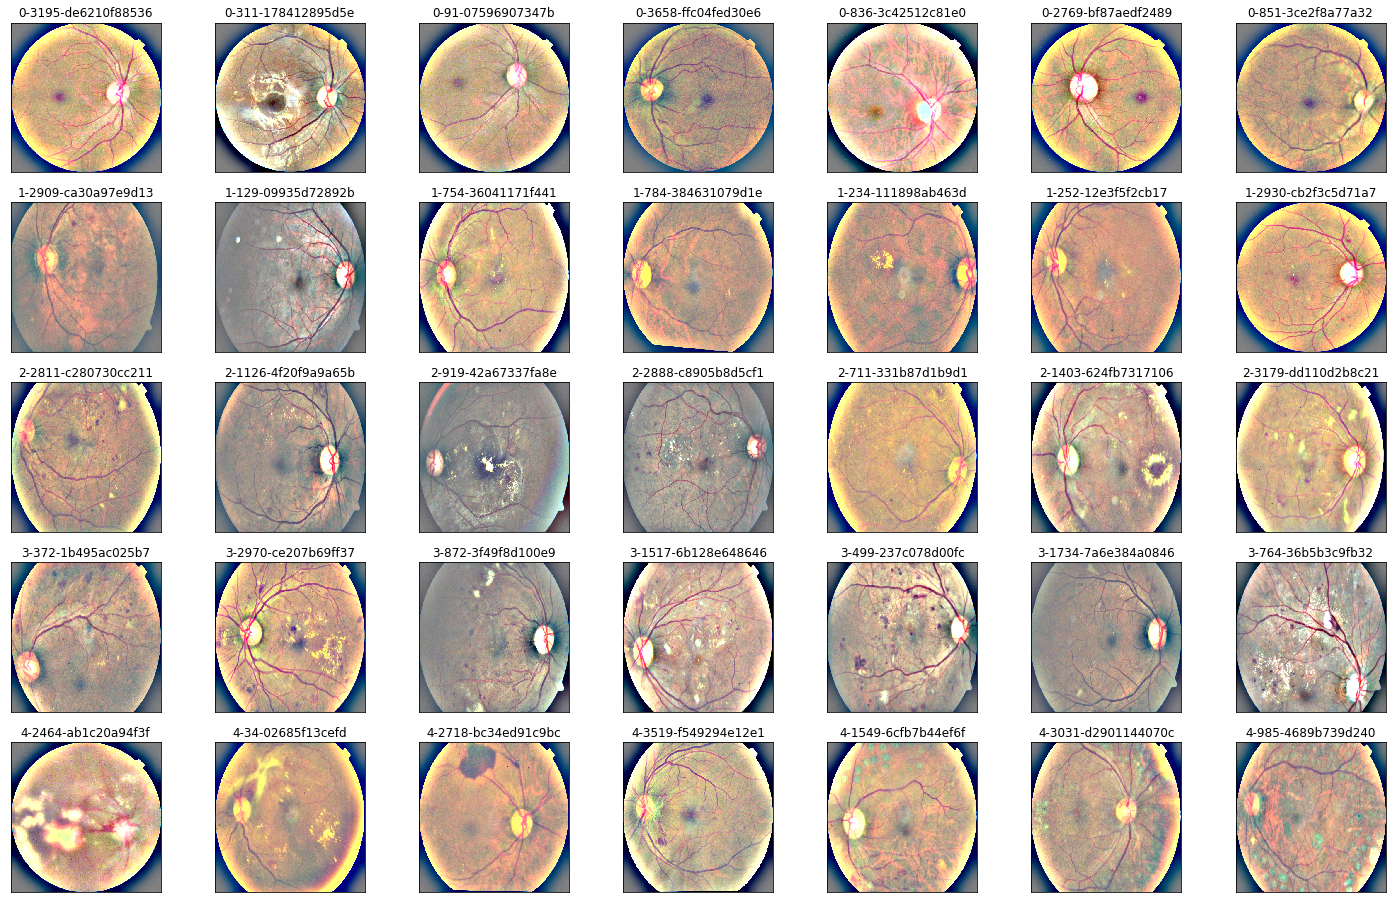

In [74]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

# Circle Crop

In [77]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

CPU times: user 1min 6s, sys: 82 ms, total: 1min 6s
Wall time: 41.4 s


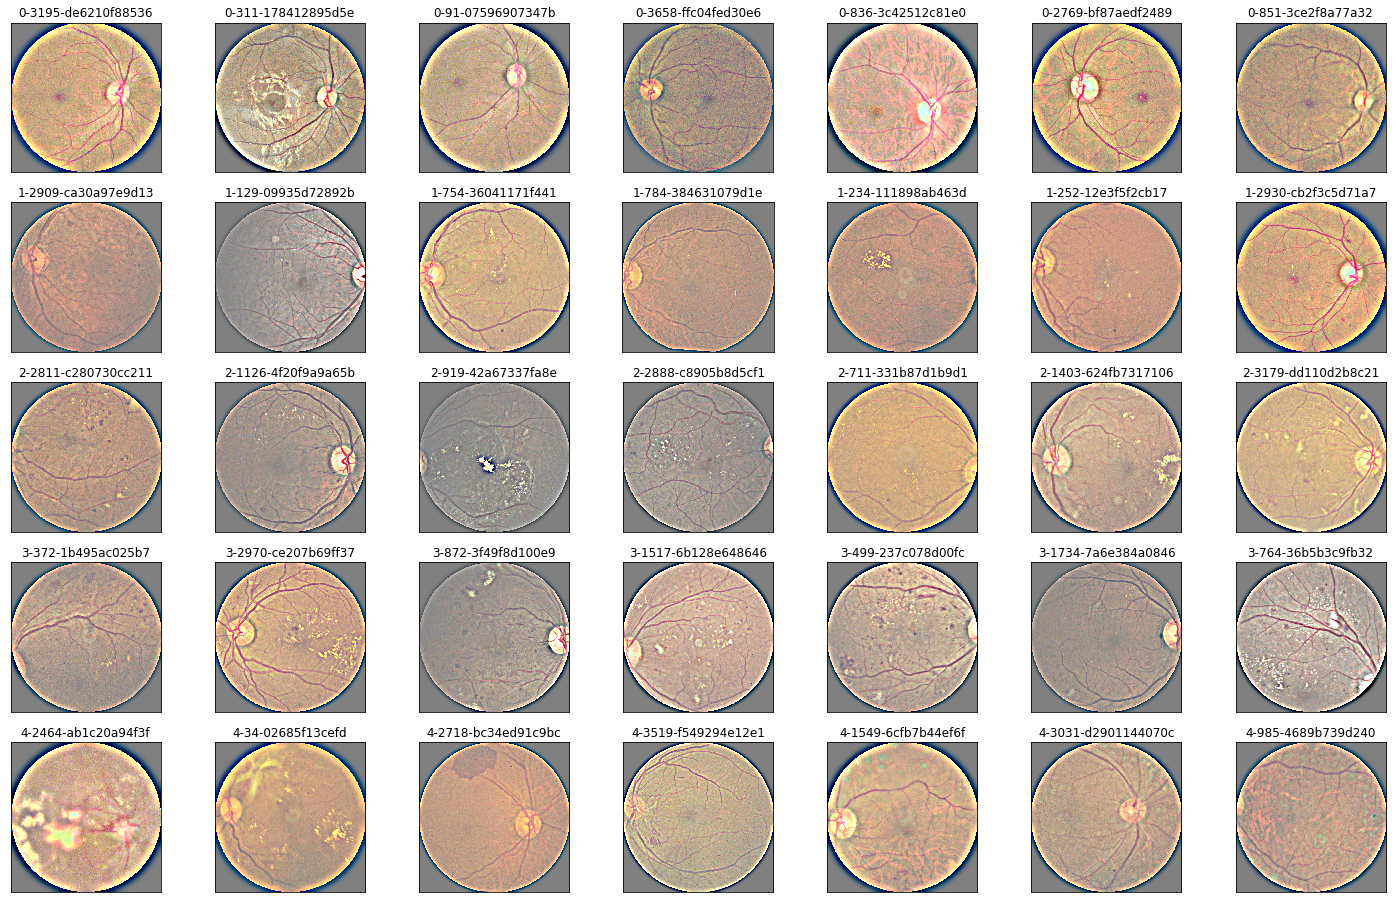

In [78]:
%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

512 512


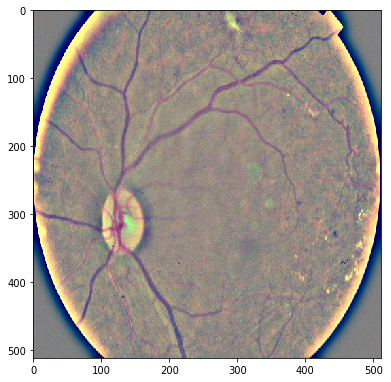

In [79]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, can be class3
image = load_ben_color(path,sigmaX=10)

height, width = IMG_DIM, IMG_DIM
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

In [80]:
df_train.id_code = df_train.id_code.apply(lambda x: x + ".png")
df_test.id_code = df_test.id_code.apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

In [81]:
# Creating the imageDatagenerator Instance 
datagenerator=ImageDataGenerator(#rescale=1./255,
#                                       validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

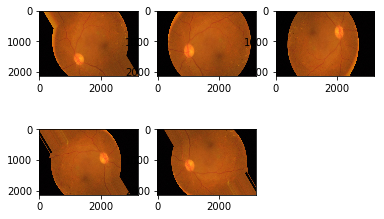

In [82]:
imgPath = f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
# Loading image
img = load_img(imgPath)
data = img_to_array(img)
samples =np.expand_dims(data, 0)
i=5
it=datagenerator.flow(samples , batch_size=1)
for i in range(5):
    plt.subplot(230 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [83]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                         validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

In [84]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )
del x_train
# # del x_test
del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


50950

In [85]:
def design_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[IMG_DIM, IMG_DIM, CHANNEL_SIZE], activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(5, activation='softmax'))
    return model


model = design_model()

In [86]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [88]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(259, 45)

# Transfer Learning

In [94]:
import tensorflow as tf

In [100]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet


model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


In [101]:
for layers in model_resnet.layers:
    layers.trainable = False

In [102]:
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # Adam(lr=lr, decay=0.01) 
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# model.summary()
gc.collect()

365

In [103]:
history = model_resnet.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     #                            shuffle=True,  
                                     callbacks=[early_stop, reduce_lr],
                                     verbose=2)
gc.collect()

NameError: name 'eraly_stop' is not defined